# "Covid-19 Portugal"
> "Simple analysis of Covid-19 evolution in Portugal"

- toc: true
- branch: master
- badges: false
- comments: true
- categories: [python, jupyter]
- image: images/covid-portugal/covid-portugal.png
- hide: false
- search_exclude: true
- show_tags: true

# COVID-19 Portugal

In [1]:
from datetime import datetime, timezone
f"Last updated: {datetime.now(tz=timezone.utc):%d %B %Y %H:%M:%S %Z}"

'Last updated: 02 November 2020 16:08:29 UTC'

## Info
Data source: https://github.com/dssg-pt/covid19pt-data

## Configuration variables

In [2]:
DATA_FILE_URL = 'https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/data.csv'
DATA_FILE_URL_CONCELHOS = 'https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/data_concelhos.csv'
DATA_FILE_URL_AMOSTRAS = 'https://raw.githubusercontent.com/dssg-pt/covid19pt-data/master/amostras.csv'

## Imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

## Load data

In [4]:
from requests import get

def download(url, file_name):
    """Download data from URL"""
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

# Target file names
DATA_FILEPATH = 'data.csv'
DATA_FILEPATH_CONCELHOS = 'data_concelhos.csv'
DATA_FILEPATH_AMOSTRAS = 'amostras.csv'        

# Download global, municipalities and samples data
download(DATA_FILE_URL, DATA_FILEPATH)
download(DATA_FILE_URL_CONCELHOS, DATA_FILEPATH_CONCELHOS)
download(DATA_FILE_URL_AMOSTRAS, DATA_FILEPATH_AMOSTRAS)

In [5]:
# Load CSVs into dataframes and fill NaN with 0
df = pd.read_csv(DATA_FILEPATH, parse_dates=[0], index_col=[0], infer_datetime_format=True)
df.fillna(value=0, inplace=True)

df_concelhos = pd.read_csv(DATA_FILEPATH_CONCELHOS, parse_dates=[0], index_col=[0], infer_datetime_format=True)
df_concelhos.fillna(value=0, inplace=True)

df_amostras = pd.read_csv(DATA_FILEPATH_AMOSTRAS, parse_dates=[0], index_col=[0], infer_datetime_format=True)
df_amostras.fillna(value=0, inplace=True)

## Overview

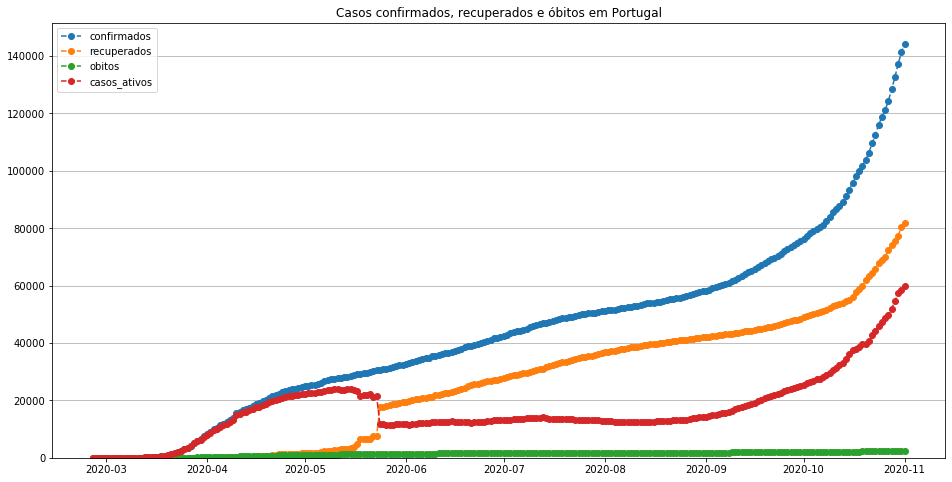

In [6]:
# Calculate active cases
df['casos_ativos'] = df['confirmados'] - df['recuperados'] - df['obitos'] 

figsize(16, 8)

fig, ax = plt.subplots()
ax.plot(df.index, df[['confirmados', 'recuperados', 'obitos', 'casos_ativos']], linestyle='--', marker='o')
ax.set_ylim(bottom=0)
plt.grid(axis='y')
plt.title('Casos confirmados, recuperados e óbitos em Portugal')
plt.legend(['confirmados', 'recuperados', 'obitos', 'casos_ativos'], loc='upper left');

## Overview concelhos

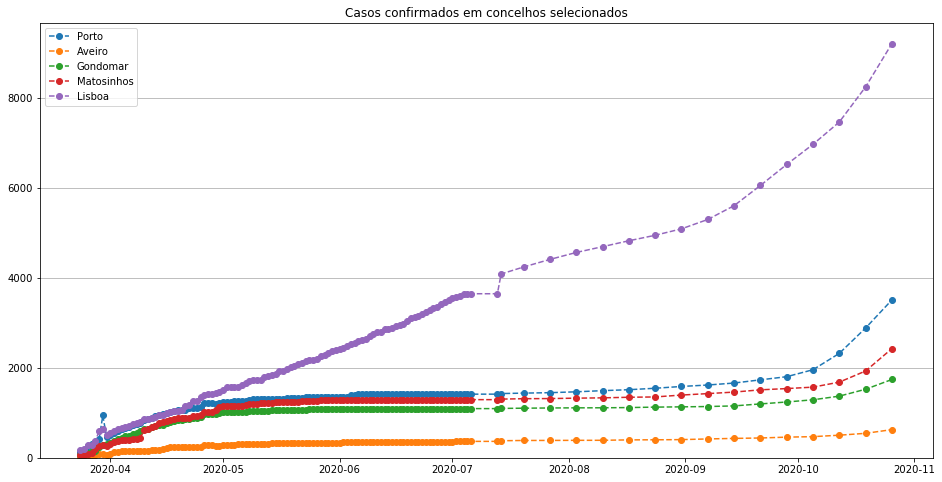

In [7]:
figsize(16, 8)

fig, ax = plt.subplots()
ax.plot(df_concelhos.index, df_concelhos[['PORTO', 'AVEIRO', 'GONDOMAR', 'MATOSINHOS', 'LISBOA']], linestyle='--', marker='o')
ax.set_ylim(bottom=0)
plt.grid(axis='y')
plt.title('Casos confirmados em concelhos selecionados')
plt.legend(['Porto', 'Aveiro', 'Gondomar', 'Matosinhos', 'Lisboa'], loc='upper left');

In [8]:
# Population data
POP_CONCELHOS = {
    'PORTO': 215284, 
    'AVEIRO': 77916, 
    'GONDOMAR': 165631, 
    'MATOSINHOS': 174382, 
    'LISBOA': 507220
}

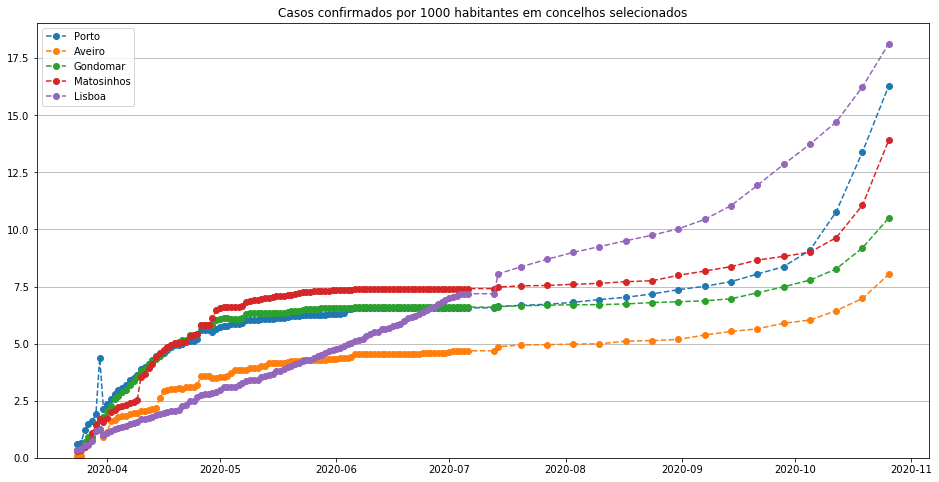

In [9]:
df_c = df_concelhos[['PORTO', 'AVEIRO', 'GONDOMAR', 'MATOSINHOS', 'LISBOA']]

for col in df_c.columns:
     df_c[col+'_p1000'] = df_c[col]/POP_CONCELHOS[col]*1000

figsize(16, 8)

fig, ax = plt.subplots()
ax.plot(df_c.index, df_c[['PORTO_p1000', 'AVEIRO_p1000', 'GONDOMAR_p1000', 'MATOSINHOS_p1000', 'LISBOA_p1000']], linestyle='--', marker='o')
ax.set_ylim(bottom=0)
plt.grid(axis='y')
plt.title('Casos confirmados por 1000 habitantes em concelhos selecionados')
plt.legend(['Porto', 'Aveiro', 'Gondomar', 'Matosinhos', 'Lisboa'], loc='upper left');

## Daily change

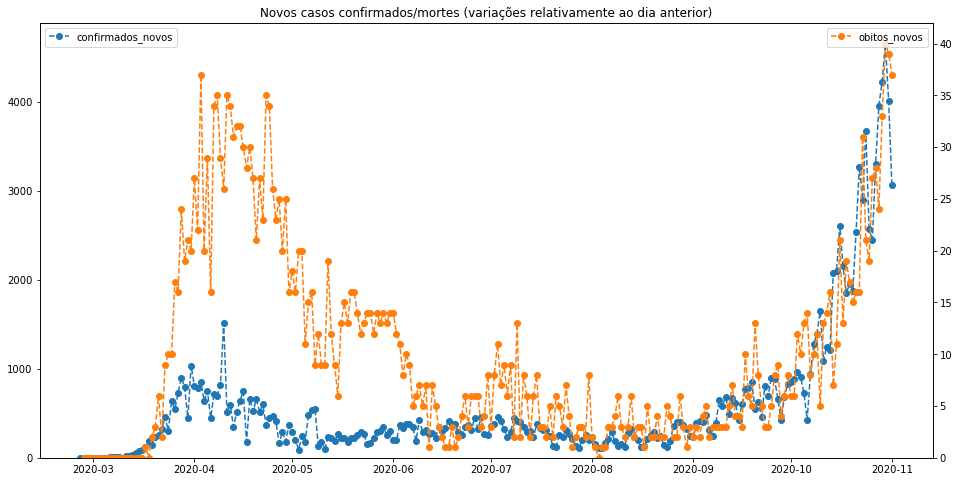

In [10]:
# Calculate daily change for new deaths (new cases already available)
df['obitos_novos'] = df.obitos.diff()

figsize(16, 8)

fig, ax1 = plt.subplots()
ax1.plot(df.index, df['confirmados_novos'], linestyle='--', marker='o')
ax2 = ax1.twinx()
ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler  # get color order from previous axis
ax2.plot(df.index, df['obitos_novos'], linestyle='--', marker='o')
ax1.legend(['confirmados_novos'], loc='upper left')
ax2.legend(['obitos_novos'], loc='upper right');
ax1.set_ylim(bottom=0);
ax2.set_ylim(bottom=0);
plt.title('Novos casos confirmados/mortes (variações relativamente ao dia anterior)');

### Rolling average

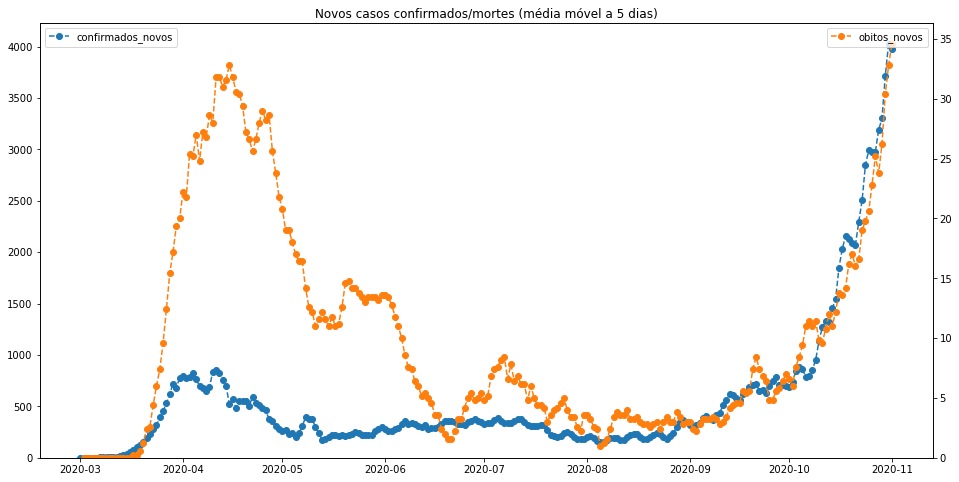

In [11]:
# Calculate rolling averages
df['confirmados_novos_rolling'] = df['confirmados_novos'].rolling(5).mean()
df['obitos_novos_rolling'] = df['obitos_novos'].rolling(5).mean()

figsize(16, 8)

fig, ax1 = plt.subplots()
ax1.plot(df.index, df['confirmados_novos_rolling'], linestyle='--', marker='o')
ax2 = ax1.twinx()
ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler  # get color order from previous axis
ax2.plot(df.index, df['obitos_novos_rolling'], linestyle='--', marker='o')
ax1.legend(['confirmados_novos'], loc='upper left')
ax2.legend(['obitos_novos'], loc='upper right');
ax1.set_ylim(bottom=0);
ax2.set_ylim(bottom=0);
plt.title('Novos casos confirmados/mortes (média móvel a 5 dias)');

## Testing

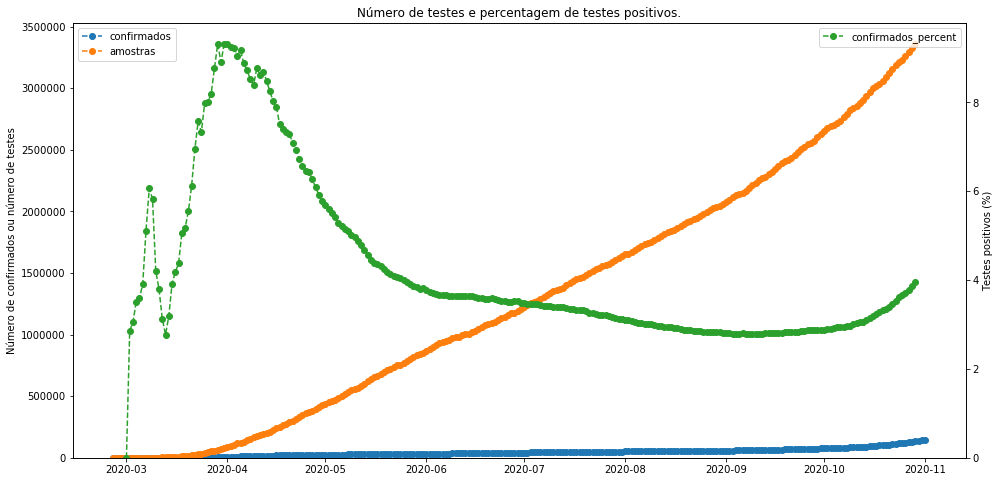

In [12]:
df['amostras'] = df_amostras['amostras']
df['amostras_novas'] = df_amostras['amostras_novas']
df['amostras_percent'] = df['confirmados']/df['amostras']*100

figsize(16, 8)

fig, ax1 = plt.subplots()
ax1.plot(df.index, df[['confirmados', 'amostras']], linestyle='--', marker='o')
ax2 = ax1.twinx()
ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler  # get color order from previous axis
ax2.plot(df.index, df['amostras_percent'], linestyle='--', marker='o')
ax1.legend(['confirmados', 'amostras'], loc='upper left')
ax2.legend(['confirmados_percent'], loc='upper right');
ax1.set_ylim(bottom=0);
ax2.set_ylim(bottom=0);
ax1.set_ylabel('Número de confirmados ou número de testes')
ax2.set_ylabel('Testes positivos (%)')
plt.title('Número de testes e percentagem de testes positivos.');

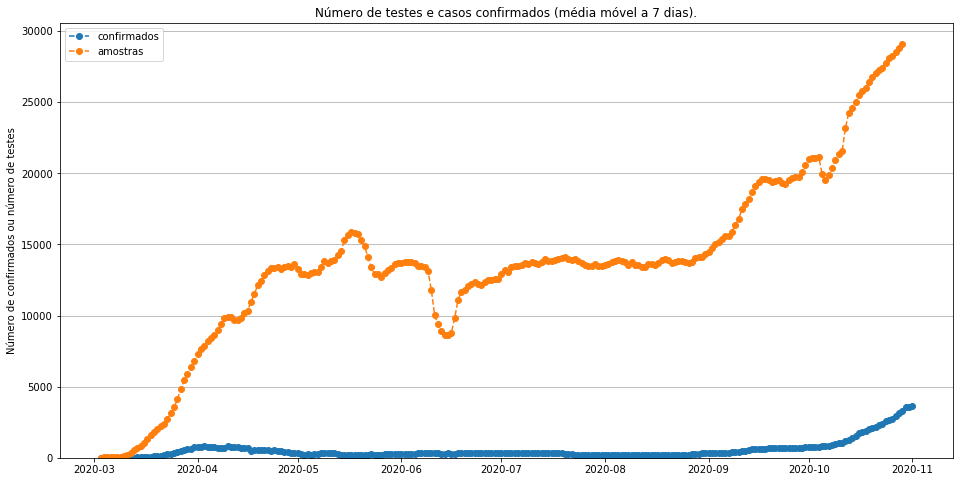

In [13]:
figsize(16, 8)

fig, ax1 = plt.subplots()
ax1.plot(df.index, df[['confirmados_novos', 'amostras_novas']].rolling(7).mean(), linestyle='--', marker='o')
ax1.legend(['confirmados', 'amostras'], loc='upper left')
ax1.set_ylim(bottom=0);
ax1.set_ylabel('Número de confirmados ou número de testes')
plt.grid(axis='y')
plt.title('Número de testes e casos confirmados (média móvel a 7 dias).');

## Age and gender distribution

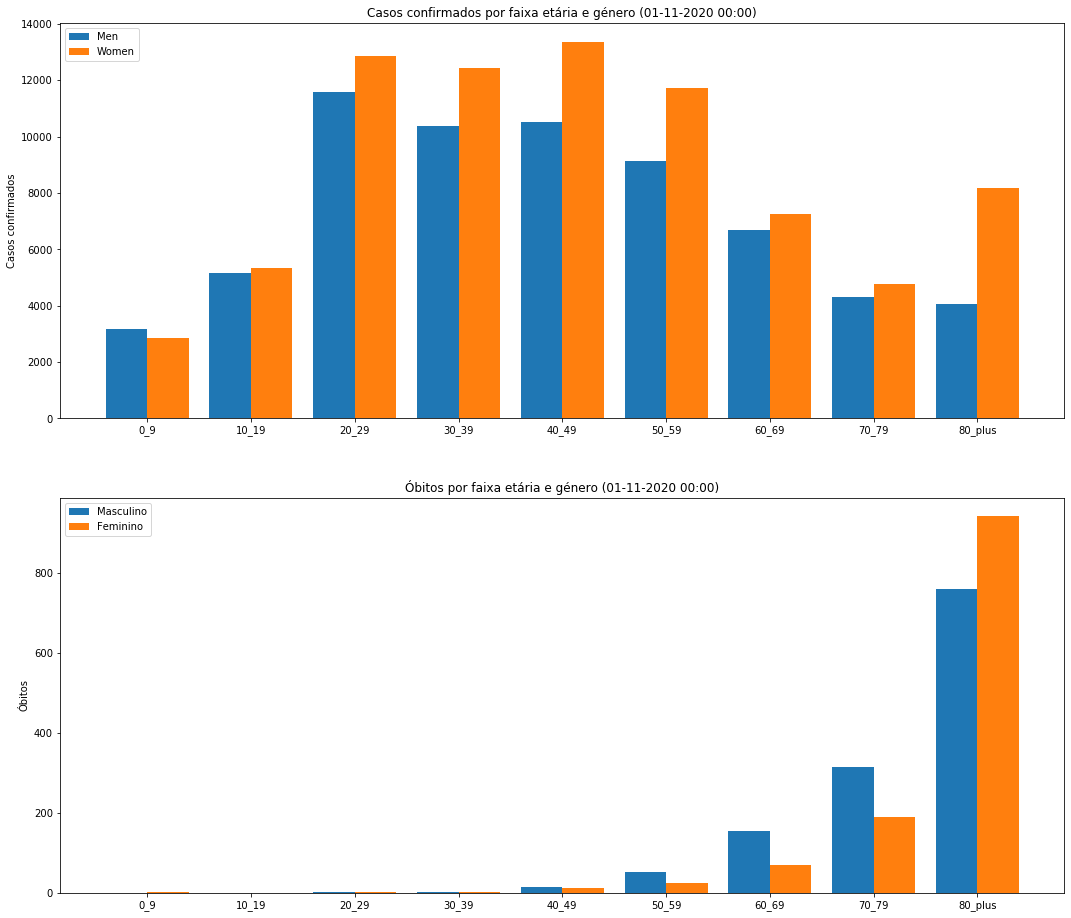

In [14]:
# List of labels of interest
confirmados_m = ['confirmados_0_9_m', 'confirmados_10_19_m', 'confirmados_20_29_m', 'confirmados_30_39_m', 'confirmados_40_49_m', 'confirmados_50_59_m', 'confirmados_60_69_m', 'confirmados_70_79_m', 'confirmados_80_plus_m']
confirmados_f = ['confirmados_0_9_f', 'confirmados_10_19_f', 'confirmados_20_29_f', 'confirmados_30_39_f', 'confirmados_40_49_f', 'confirmados_50_59_f', 'confirmados_60_69_f', 'confirmados_70_79_f', 'confirmados_80_plus_f']
obitos_m = ['obitos_0_9_m', 'obitos_10_19_m', 'obitos_20_29_m', 'obitos_30_39_m', 'obitos_40_49_m', 'obitos_50_59_m', 'obitos_60_69_m', 'obitos_70_79_m', 'obitos_80_plus_m']
obitos_f = ['obitos_0_9_f', 'obitos_10_19_f', 'obitos_20_29_f', 'obitos_30_39_f', 'obitos_40_49_f', 'obitos_50_59_f', 'obitos_60_69_f', 'obitos_70_79_f', 'obitos_80_plus_f']

# Create final labels for plots
age_labels = [label.replace('confirmados_', '').replace('_m', '') for label in confirmados_m]

# X ticks and bar widths
x = np.arange(len(confirmados_m))
bar_width = 0.4

figsize(18, 16)

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.bar(x - bar_width/2, df.iloc[-1][confirmados_m], bar_width, label='Men')
ax1.bar(x + bar_width/2, df.iloc[-1][confirmados_f], bar_width, label='Women')
ax1.set_ylabel('Casos confirmados')
ax1.set_title(f'Casos confirmados por faixa etária e género ({df.iloc[-1]["data_dados"]})')
ax1.set_xticks(x)
ax1.set_xticklabels(age_labels)
ax1.legend(loc='upper left')

ax2.bar(x - bar_width/2, df.iloc[-1][obitos_m], bar_width, label='Masculino')
ax2.bar(x + bar_width/2, df.iloc[-1][obitos_f], bar_width, label='Feminino')
ax2.set_ylabel('Óbitos')
ax2.set_title(f'Óbitos por faixa etária e género ({df.iloc[-1]["data_dados"]})')
ax2.set_xticks(x)
ax2.set_xticklabels(age_labels)
ax2.legend(loc='upper left');

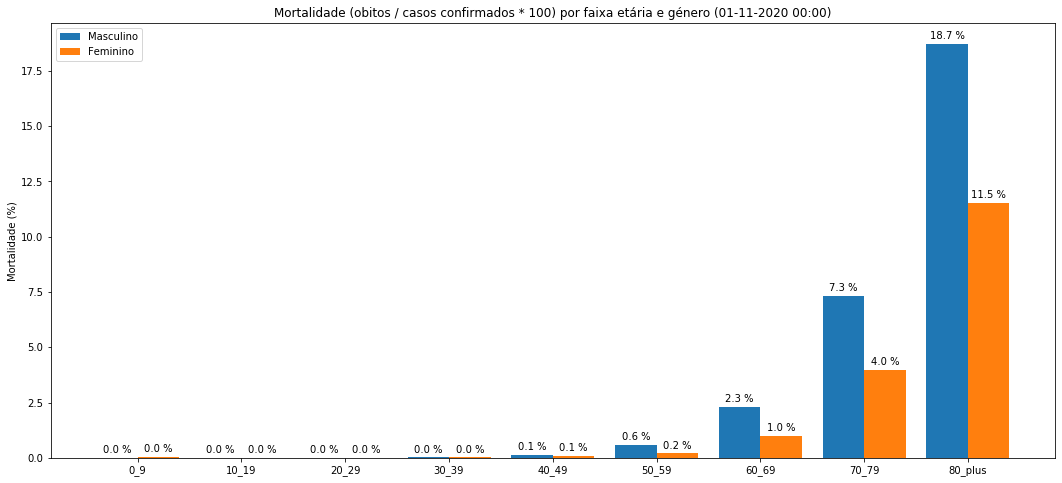

In [15]:
# Calculate morality rate (obitos / casos confirmados * 100)
mortality_m = []
for confirmados, obitos, age in zip(confirmados_m, obitos_m, age_labels):
    mortality_m.append('mortality_percent_' + age + '_m')
    df['mortality_percent_' + age + '_m'] = df[obitos] / df[confirmados] * 100

mortality_f = []
for confirmados, obitos, age in zip(confirmados_f, obitos_f, age_labels):
    mortality_f.append('mortality_percent_' + age + '_f')
    df['mortality_percent_' + age + '_f'] = df[obitos] / df[confirmados] * 100
    
    
figsize(18, 8)

fig, ax = plt.subplots()

rects1 = ax.bar(x - bar_width/2, df.iloc[-1][mortality_m], bar_width, label='Masculino')
rects2 = ax.bar(x + bar_width/2, df.iloc[-1][mortality_f], bar_width, label='Feminino')
ax.set_ylabel('Mortalidade (%)')
ax.set_title(f'Mortalidade (obitos / casos confirmados * 100) por faixa etária e género ({df.iloc[-1]["data_dados"]})')
ax.set_xticks(x)
ax.set_xticklabels(age_labels)
ax.legend(loc='upper left');

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f} %'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

## Monitoring

- lab: Número de casos suspeitos a aguardar resultados laboratoriais
- suspeitos: Total de casos suspeitos (tendo a definição sido actualizada a 29/02/2020) desde 01/01/2020
- vigilancia: Número de casos sob vigilância pelas autoridades de saúde 
- n_confirmados: Número de casos cuja suspeita de infecção não se confirmou
- internados: Número de pacientes COVID-19 internados
- internados_uci: Número de pacientes COVID-19 internados em Unidades de Cuidados Intensivos

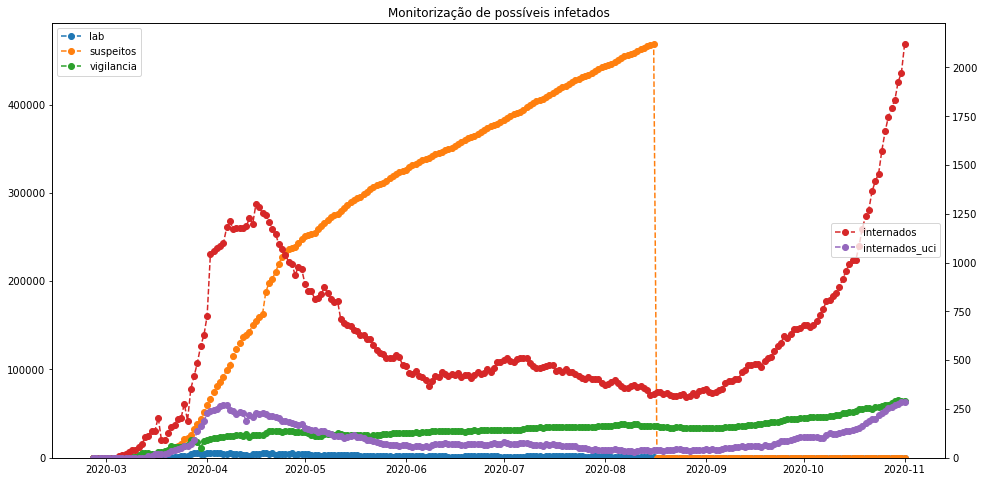

In [16]:
monitoring = ['lab', 'suspeitos', 'vigilancia', 'n_confirmados', 'internados', 'internados_uci']

figsize(16, 8)

fig, ax1 = plt.subplots()
ax1.plot(df.index, df[monitoring[0:3]], linestyle='--', marker='o')
ax2 = ax1.twinx()
ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler  # get color order from previous axis
ax2.plot(df.index, df[monitoring[4:6]], linestyle='--', marker='o')
ax1.legend(monitoring[0:3], loc='upper left')
ax2.legend(monitoring[4:6], loc='center right');
ax1.set_ylim(bottom=0);
ax2.set_ylim(bottom=0);
plt.title('Monitorização de possíveis infetados');

## Symptoms

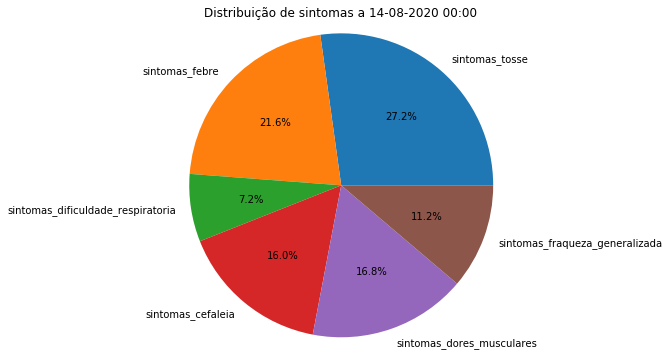

In [18]:
figsize(6, 6)

symptoms = ['sintomas_tosse', 'sintomas_febre', 'sintomas_dificuldade_respiratoria', 'sintomas_cefaleia', 'sintomas_dores_musculares', 'sintomas_fraqueza_generalizada']

fig, ax = plt.subplots()
ax.pie(df.iloc[170][symptoms], labels=symptoms, autopct='%1.1f%%')
ax.axis('equal')
plt.title(f'Distribuição de sintomas a {df.iloc[170]["data_dados"]}');